In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from common import geo_to_cartesian_m, calculate_centroids, cartesian_to_geo

In [2]:
RADIUS_EARTH_KM = 6373.0
RADIUS_EARTH_M = RADIUS_EARTH_KM * 1000

In [3]:
df = pd.read_csv("data/mappers_processed.csv")

In [4]:
# Limit to SF Bay
lat_bounds = [37, 38]
long_bounds = [-124, -122]

df = df[df["target_lat"] > lat_bounds[0]]
df = df[df["target_lat"] < lat_bounds[1]]
df = df[df["target_long"] > long_bounds[0]]
df = df[df["target_long"] < long_bounds[1]]


In [5]:
# Limit the number of samples
max_samples = 10000
if df.shape[0] > max_samples:
    print(f"Limiting # samples from {df.shape[0]} to {max_samples}")
    df = df.sample(n=max_samples)


Limiting # samples from 413023 to 10000


Text(0, 0.5, 'Latitude')

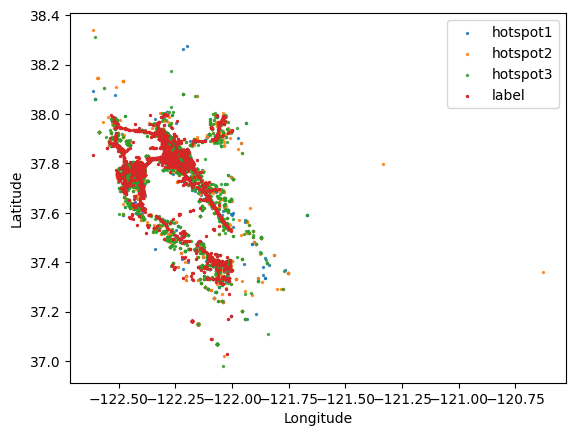

In [6]:
subset = df.sample(n=min(len(df), 5000))
for i in range(1,4):
    plt.scatter(subset[f"hotspot{i}_long"], subset[f"hotspot{i}_lat"], s=2, alpha=0.8, label=f"hotspot{i}")
plt.scatter(subset["target_long"], subset["target_lat"], s=2, label="label")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [7]:
data = np.concatenate([
    df[[f"{prefix}_lat", f"{prefix}_long"]].to_numpy() for prefix in ["target", "hotspot1", "hotspot2", "hotspot3"]
])
print(data.shape)

(40000, 2)


In [8]:
def haversine_np(lat_long_deg_1, lat_long_deg_2, radius:float=RADIUS_EARTH_KM):
    """
    Calculate the great circle distance between two points on a sphere
    ie: Shortest distance between two points on the surface of a sphere
    """
    lat_1, lon_1, lat_2, lon_2 = map(np.deg2rad, [lat_long_deg_1[:,0], lat_long_deg_1[:,1], lat_long_deg_2[:,0], lat_long_deg_2[:,1]])
    d = np.sin((lat_2 - lat_1)/2)**2 + np.cos(lat_1)*np.cos(lat_2) * np.sin((lon_2 - lon_1)/2)**2
    arc_len = 2 * radius * np.arcsin(np.sqrt(d))
    return arc_len

def k_means(data, k:int=50, num_iter:int=50, seed:int=42, trace: bool=False):
    np.random.seed(seed)

    n, d = data.shape
    # Pre-compute cartesian coordinates for each data point
    data_xyz_m = geo_to_cartesian_m(
        lat_long_alt=np.stack([data[:,0], data[:,1], np.zeros((n))], axis=1)
    )
    # Initialize centroids as random selection of data points
    centroids = data[np.random.choice(n, k, replace=False)] # k, d 
    diff = np.zeros((n,k))

    for _ in tqdm(range(num_iter), disable=not trace):
        # Assign centroids based on minimum haversine distance
        for i in range(k):
            diff[:, i] = haversine_np(data, centroids[np.newaxis, i,:])
        labels = diff.argmin(axis=1) # n,

        # Update the centroids to be the projected centroid of the members of each cluster
        for i in range(k):
            members_xyz_m = data_xyz_m[np.argwhere(labels==i), :]
            if members_xyz_m.shape[0] == 0:
                # empty cluster... don't update
                continue
            centroid_xyz_m = calculate_centroids(coordinates_xyz_m=members_xyz_m[:, :], project=True)
            centroid_lat_long = cartesian_to_geo(xyz_m=centroid_xyz_m)[:,:2]
            centroids[i] = centroid_lat_long
        
    return centroids

In [9]:
# Cluster
centroids = k_means(data, k=2000, trace=True)

100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


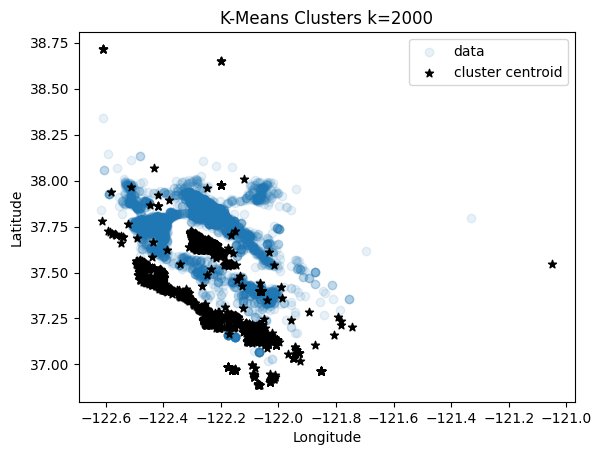

In [10]:
# Visualize clusters
subset = data[np.random.choice(data.shape[0], min(10000, data.shape[0]), replace=False), :]
plt.scatter(subset[:,1], subset[:,0], alpha=0.1, label="data")
plt.scatter(centroids[:,1], centroids[:,0], marker="*", color="k", label="cluster centroid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title(f"K-Means Clusters k={centroids.shape[0]}")
plt.show()

In [11]:
# Start by dividing the lat/long area into an evenly spaced grid of clusters
n_div_lat = 100
n_div_long = 500
lat_min_max = [np.min(data[:,0]), np.max(data[:,0])]
long_min_max = [np.min(data[:,1]), np.max(data[:,1])]
cluster_div_lat = np.linspace(np.min(data[:,0]), np.max(data[:,0]),  n_div_lat)
cluster_div_long = np.linspace(np.min(data[:,1]), np.max(data[:,1]),  n_div_long)
centroids = np.zeros((cluster_div_lat.shape[0]*cluster_div_long.shape[0], 2))
for i, lat in enumerate(cluster_div_lat):
    for j, long in enumerate(cluster_div_long):
        centroids[i * n_div_long + j] = [lat, long]

# Then cluster the data points to the nearest "cluster" based on haversine dist
n = data.shape[0]
k = centroids.shape[0]
# Assign centroids based on minimum haversine distance
diff = np.zeros((n,k))
for i in tqdm(range(k)):
    diff[:, i] = haversine_np(data, centroids[np.newaxis, i,:])
labels = diff.argmin(axis=1) # n,

# Remove any clusters that have no data points... 
# this reduces the final number of clusters while keeping an even spacing
populated_centroid_idxs = np.array(sorted(np.unique(labels)))
centroids = centroids[populated_centroid_idxs, :]
label_mapping = {idx: i for i, idx in enumerate(populated_centroid_idxs)}
labels = np.array([label_mapping[label] for label in labels])
print(centroids.shape)

100%|██████████| 50000/50000 [01:31<00:00, 543.62it/s]


(1849, 2)


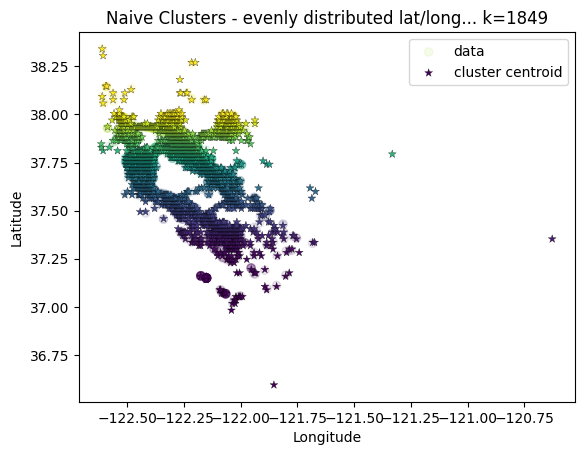

In [12]:
# Visualize clusters
sample_idxs = np.random.choice(data.shape[0], min(10000, data.shape[0]), replace=False)
subset = data[sample_idxs, :]
plt.scatter(subset[:,1], subset[:,0], alpha=0.1, c=labels[sample_idxs], label="data")
plt.scatter(centroids[:,1], centroids[:,0], marker="*", linewidth=0.2, edgecolors='k', c=np.arange(centroids.shape[0]), label="cluster centroid")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title(f"Naive Clusters - evenly distributed lat/long... k={centroids.shape[0]}")
plt.show()